<a href="https://colab.research.google.com/github/arieljassan/marketing-campaign-generation/blob/main/Lab_Automate_marketing_campaign_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab: Automating marketing campaign generation using Enterprise Search, Vertex AI, Stable Diffusion, and Imagen

<table align="center">
  <td>
    <a href="https://colab.research.google.com/github/arieljassan/marketing-campaign-generation/blob/main/Lab_Automate_marketing_campaign_generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/arieljassan/marketing-campaign-generation/Lab_Automate_marketing_campaign_generation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

### Introduction
In this lab we will automate the creation of a marketing campaigns using Google Cloud and open source products, including Enterprise Search, Vertex LLM, Vertex Imagen, and Stable Diffusion.

### Prerequisites
We assume you already have an Enterprise Search app and you have permissions to access Vertex Language models, Vertex Imagen, Enterprise Search, and a Vertex API Endpoint to a Stable Diffusion model.
We also assume you have permissions to run Enterprise Search and Vertex.

To create an Enterprise Search app you can follow the instructions in [this colab](https://colab.research.google.com/github/arieljassan/marketing-campaign-generation/blob/Lab_Creating_a_data_store_in_Enterprise_Search.ipynb).

### Objectives
1. Query Enterprise Search about a product using the Python SDK or the REST API.
1. Generate title, body, and keywords for a marketing campaign using Vertex LLM.
1. Create images using Stable Diffusion and Vertex Imagen.


### Documentation
* Enterprise Search Integration guide can be [found here](https://cloud.devsite.corp.google.com/discovery-engine/gen-app-builder/docs/create-datastore-ingest)
* Enterprise Search - getting search results using the Python SDK can be [found here](https://cloud.google.com/generative-ai-app-builder/docs/preview-search-results)
* Discovery Engine types in Python SDK can be [found here](https://github.com/googleapis/google-cloud-python/blob/main/packages/google-cloud-discoveryengine/google/cloud/discoveryengine_v1/types/search_service.py)
* Python Client for Discovery Engine API can be [found here](https://cloud.google.com/python/docs/reference/discoveryengine/latest)


### Disclaimer
This lab is for educational purposes only and not intended for use in production.


## Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI Generative AI
* Enterprise Search
* Google Cloud Storage pricing

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), [Generative AI App Builder pricing](https://cloud.google.com/generative-ai-app-builder/pricing)
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Workflow

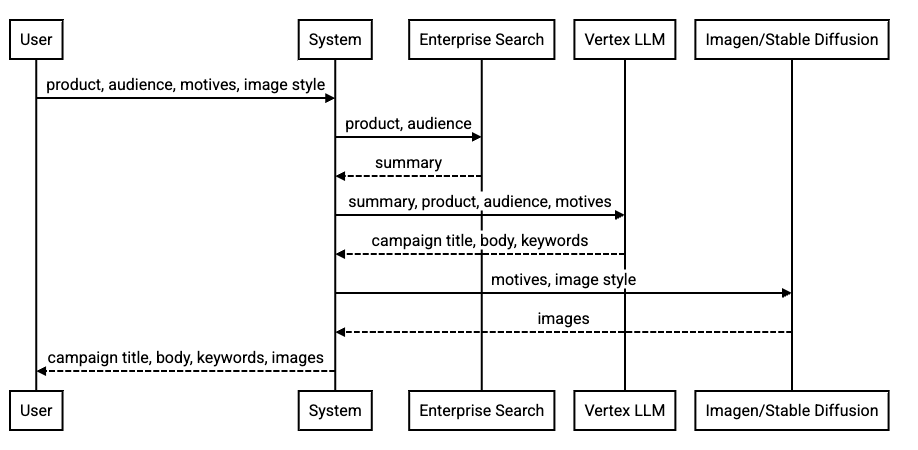

# Set up environment

In [1]:
!pip install google-cloud-aiplatform google-cloud-discoveryengine --upgrade --user --quiet --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 523.5/523.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 29.5 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# Colab only: Automatically restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
#@title Authenticating your notebook environment
from google.colab import auth
auth.authenticate_user()

In [2]:
# @title Set project parameters
PROJECT_ID = 'your-project-id' #@param {type: 'string'}
DATASTORE = 'your-datastore-id' #@param {type:'string'}
LLM_MODEL = 'text-bison@001' #@param 'text-bison@001' {type: 'string'}
VERTEX_REGION = 'us-central1' #@param "us-central1" {type: 'string'}
IMAGEN_MODEL = 'imagegeneration@002' #@param 'imagegeneration@002' {type: 'string'}

# Parameters for custom Enterprise Search class
API_ENDPOINT = 'prod' #@param ['prod', 'staging', 'dev'] {type: 'string', allow-input: true}
PRINT_REQUESTS = True #@param {type: 'boolean'}

# Parameters of Stable Diffusion endpoint
STABLE_DIFFUSION_PROJECT = 'your-stable-diffusion-project' #@param {type: 'string'}
STABLE_DIFFUSION_ENDPOINT = 'your-stable-diffusion-endpoint' #@param {type: 'string'}
STABLE_DIFFUSION_REGION = 'us-central1' #@param "us-central1" {type: 'string'}

# Define libraries, classes, and methods

In [17]:
# @title [Optional] Import libraries and define custom `UCSClient` class
# The UCSClient class provides a wrapper around the REST API to take advantage
# of the mothods available only through the REST API.
import requests, json, time
from requests.exceptions import HTTPError
import google.auth
from google.colab.auth import authenticate_user
from typing import Optional, List, Dict

class UCSClient():
  POLL_INTERVAL = 30 # seconds
  TIMEOUT = None # seconds or None
  API_ENDPOINTS = ['dev', 'staging', 'prod']
  METHODS = ['get', 'post', 'patch', 'delete']

  def __init__(self, project_id: str, location: str='global', endpoint: str='prod', debug: bool=False):
    if endpoint not in self.API_ENDPOINTS:
      raise ValueError(f"endpoint must be one of {self.API_ENDPOINTS}")
    self.project_id = project_id
    self.location = location
    self._debug = debug
    self._urls = {
        'prod': "https://discoveryengine.googleapis.com",
        'staging': "https://staging-discoveryengine.sandbox.googleapis.com",
        'dev': "https://test-discoveryengine.sandbox.googleapis.com"
    }
    self._base_url = self._urls[endpoint]
    self._version = 'v1alpha'
    self._creds = None
    self.datastore = None

    self._set_base_url()
    self._auth_session()

  def _set_base_url(self):
    """Helper class to set the base URL"""
    self._url = f"{self._base_url}/"
    if self._version != '':
      self._url += f"{self._version}/"
    self._url += f"projects/{self.project_id}/locations/{self.location}/collections/default_collection"

  def use_prod(self):
    """Switch to using the prod API endpoints"""
    print("Switching to the prod API")
    self._base_url = self._urls['prod']
    self._set_base_url()

  def use_staging(self):
    """Switch to using the staging API endpoints"""
    print("Switching to the staging API")
    self._base_url = self._urls['staging']
    self._set_base_url()

  def use_dev(self):
    """Switch to using the dev API endpoints"""
    print("Switching to the dev API")
    self._base_url = self._urls['dev']
    self._set_base_url()

  def _auth_session(self):
    self._session = requests.Session()
    authenticate_user()
    creds, project = google.auth.default()
    self._creds = creds
    auth_req = google.auth.transport.requests.Request()
    self._creds.refresh(auth_req)
    self._session.headers.update({
          'X-Goog-User-Project': self.project_id,
          'Authorization': f"Bearer {self._creds.token}",
          'Content-Type': "application/json; charset=utf-8",
          })

  def refresh_credentials(self):
    """Refresh the auth token"""
    auth_req = google.auth.transport.requests.Request()
    self._creds.refresh(auth_req)
    self._session.headers.update({'Authorization': f"Bearer {self._creds.token}"})

  def set_datastore(self, datastore_id:str):
    """Set a datastore as default"""
    self.datastore = datastore_id

  def _make_request(self, method:str, endpoint:str, *args, **kwargs):
    if method not in self.METHODS:
      raise ValueError(f"method must be one of {self.METHODS}")
    methods = {
        'get': self._session.get,
        'post': self._session.post,
        'patch': self._session.patch,
        'delete': self._session.delete,
    }
    if self._debug and not kwargs.pop('silent', False):
      print(f"""{method.upper()} {endpoint}
{args or ''}
{kwargs or ''}
""")
    r = methods[method](endpoint, *args, **kwargs)
    try:
      r.raise_for_status()
    except HTTPError as e:
      if e.response.status_code == 401:
        self.refresh_credentials()
        r = methods[method](endpoint, *args, **kwargs)
        r.raise_for_status()
      else:
        raise e
    return r.json()

  def _get_datastore(self, datastore:Optional[str]):
    """Fetch a datastore from class attributes or arg"""
    ds = self.datastore if datastore is None else datastore
    if not ds:
      raise ValueError("Must pass a value to datastore_id")
    else:
      return ds

  def _poll(self, operation_id:str, datastore_id:Optional[str]=None, branch_id:str='0', silent:bool=True):
    """Poll an operation status until response['done'] == True"""
    ds = self._get_datastore(datastore_id)
    url = f"{self._url}/dataStores/{ds}/branches/{branch_id}/operations/{operation_id}"
    elapsed = 0
    while True:
      r = self._make_request('get', url, silent=silent)
      if r.get('done', False):
        return r
      else:
        time.sleep(self.POLL_INTERVAL)
        if self.TIMEOUT is not None and (elapsed + self.POLL_INTERVAL >= self.TIMEOUT):
          raise Exception("Polling did not complete successfully before timeout")
        elapsed += self.POLL_INTERVAL


  def search(self, query:Dict, datastore_id:Optional[str]=None, serving_config_id:str='default_config'):
    """Run a search against a datastore and serving config"""
    ds = self._get_datastore(datastore_id)
    url = f"{self._url}/dataStores/{ds}/servingConfigs/{serving_config_id}:search"
    return self._make_request('post', url, data=json.dumps(query))


In [18]:
# @title [Optional] Initialize custom custom `UCSClient`
rest_client = UCSClient(project_id=PROJECT_ID, endpoint=API_ENDPOINT, debug=PRINT_REQUESTS)

In [3]:
# @title Methods for Enterprise Search Python SDK
from google.cloud import discoveryengine_v1 as de

SERVING_CONFIG = f"projects/{PROJECT_ID}/locations/global/collections/default_collection"

# Create a client.
es_sdk_client = de.SearchServiceClient()

def es_sdk_search(query, page_size, offset):
  request = de.SearchRequest(
    serving_config = f'{SERVING_CONFIG}/dataStores/{DATASTORE}/servingConfigs/default_search:search',
    query = query,
    page_size = page_size,
    offset = offset,
    content_search_spec = de.SearchRequest.ContentSearchSpec(
        summary_spec = de.SearchRequest.ContentSearchSpec.SummarySpec(
            summary_result_count = 5,
            include_citations = False),
        snippet_spec = de.SearchRequest.ContentSearchSpec.SnippetSpec(
            return_snippet = True)))

  # Make the request.
  page_result = es_sdk_client.search(request=request)

  return page_result

In [5]:
# @title Import and initialize Vertex LLM and Imagen
import json
import vertexai

from vertexai.language_models import TextGenerationModel
from vertexai.preview.vision_models import ImageGenerationModel

vertexai.init(project=PROJECT_ID, location=VERTEX_REGION)
generation_model = TextGenerationModel.from_pretrained(LLM_MODEL)

In [6]:
# @title Methods for Stable Diffusion model
# For complete colab, see
# https://colab.sandbox.google.com/drive/1xQzhNnY2_D6P-IPzsthxY-k8qb19yPT6

from typing import Dict, List, Union

import base64
import io
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image

from google.cloud import aiplatform
from google.cloud import storage
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


def image_to_base64(image, format="JPEG"):
  buffer = BytesIO()
  image.save(buffer, format=format)
  image_str = base64.b64encode(buffer.getvalue()).decode("utf-8")
  return image_str


def base64_to_image(image_str):
  image = Image.open(BytesIO(base64.b64decode(image_str)))
  return image


def predict_custom_trained_model_sample(
  project: str,
  endpoint_id: str,
  instances: Union[Dict, List[Dict]],
  location: str = "us-central1",
  api_endpoint: str = "us-central1-aiplatform.googleapis.com"):


  # The AI Platform services require regional API endpoints.
  client_options = {"api_endpoint": api_endpoint}

  # Initialize client that will be used to create and send requests.
  # This client only needs to be created once, and can be reused for multiple requests.
  client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)

  # The format of each instance should conform to the deployed model's prediction input schema.
  instances = instances if type(instances) == list else [instances]
  instances = [
      json_format.ParseDict(instance_dict, Value()) for instance_dict in instances
  ]
  parameters_dict = {}
  parameters = json_format.ParseDict(parameters_dict, Value())
  endpoint = client.endpoint_path(
      project=project, location=location, endpoint=endpoint_id
  )
  response = client.predict(
      endpoint=endpoint, instances=instances, parameters=parameters
  )
  print("response")
  print(" deployed_model_id:", response.deployed_model_id)
  # The predictions are a google.protobuf.Value representation of the model's
  # predictions.
  predictions = response.predictions
  return predictions


def generateImageFromPrompt(text):
  return predict_custom_trained_model_sample(
      project = STABLE_DIFFUSION_PROJECT,
      endpoint_id = STABLE_DIFFUSION_ENDPOINT,
      location = STABLE_DIFFUSION_REGION,
      instances = [{
          "prompt": text,
          "negative_prompt": """ugly, tiling, poorly drawn hands,
              poorly drawn feet, poorly drawn face, out of frame, extra limbs,
              disfigured, deformed, body out of frame, bad anatomy, watermark,
              signature, cut off, low contrast, underexposed, overexposed,
              bad art, beginner, amateur, distorted face"""}])

# Generate the marketing campaign

In [7]:
# @title Set parameters for the marketing campaign
product = 'Pixel 7 Pro' #@param {type: "string"}
audience = 'young audiences' #@param {type: "string"}
motives = 'beach, sun' #@param {type: "string"}
word_count = 200 #@param {type: "integer"}
image_style = 'digital art' #@param {type: "string"}

In [10]:
# @title Prompt for Enterprise Search
es_prompt = f'List 5 facts about {product} that appeal to {audience}.'

In [23]:
# @title [Optional] Search via `UCSClient`
# The REST API provides extractive answers and extractive segments, which are
# not yet available via the Python SDK.

# Querying via UCSclient.
rest_api_query = {
    "query": es_prompt,
    "pageSize": "3",
    "offset": "0",
    "orderBy": "",
    "filter": "",
    "contentSearchSpec": {
        "summarySpec": {
            "summaryResultCount": 5,
            "includeCitations": False
        },
        "extractiveContentSpec": {
            "maxExtractiveAnswerCount": 3,
            "maxExtractiveSegmentCount": 3
        },
        "snippetSpec": {
          "returnSnippet": True
        }
    }
}

es_ucs_response = rest_client.search(rest_api_query, datastore_id=DATASTORE)

# Summary using the UCSClient.
es_ucs_summary = es_ucs_response['summary']['summaryText']

# Extractive answers and extractive segments.
es_segments = []
es_answers = []
for result in es_ucs_response['results']:
  segment = result['document']['derivedStructData']['extractive_segments'][0]['content']
  answer = result['document']['derivedStructData']['extractive_answers'][0]['content']
  es_segments.append(segment)
  es_answers.append(answer)

es_answers

POST https://discoveryengine.googleapis.com/v1alpha/projects/arielj-argolis-1/locations/global/collections/default_collection/dataStores/gstore1_1695199087646/servingConfigs/default_config:search

{'data': '{"query": "List 5 facts about Pixel 7 Pro that appeal to young audiences.", "pageSize": "3", "offset": "0", "orderBy": "", "filter": "", "contentSearchSpec": {"summarySpec": {"summaryResultCount": 5, "includeCitations": false}, "extractiveContentSpec": {"maxExtractiveAnswerCount": 3, "maxExtractiveSegmentCount": 3}, "snippetSpec": {"returnSnippet": true}}}'}



['It helps people with low vision take the best selfies by using audio and haptics to ensure a face is right in frame. Performance Helpful features, throughout your day. Pixel 7 Pro is helpful all around, with a long-lasting battery and so much more. What you need, when you need it.',
 'DisplayRear cameraProcessorMemoryBattery and chargingSecurity and authentication FHD+ OLED Smooth Display,up to 90 Hz Dual rear camera system: Wide lens, ultrawide lens — — — Google Tensor G2 4385 mAh 24+ hour battery life Wireless charging — Titan M2™ chip &amp; security core Fingerprint Unlock Face Unlock VPN by Google One FHD+ OLED Smooth Display,up to 90 Hz Dual rear camera system: Wide lens, ultrawide lens — — — Google Tensor G2 4355 mAh 24+ hour battery life Fast Wireless charging Battery Share Titan M2™ chip &amp; security core Fingerprint Unlock Face Unlock VPN by Google One QHD+ LTPO OLED Smooth Display,up to 120 Hz Triple rear camera system: Wide lens, ultrawide lens, telephoto lens — — — Goog

In [24]:
#@title Search via Discovery Engine Python SDK
es_sdk_response = es_sdk_search(query=es_prompt, page_size=0, offset=0)
es_sdk_summary = es_sdk_response.summary.summary_text
es_sdk_summary

'The Pixel 7 Pro is a powerful phone with a long-lasting battery. It has a triple rear camera system with a 50MP wide lens, a 12MP ultrawide lens, and a 48MP telephoto lens. The phone also has a 12MP front-facing camera. The Pixel 7 Pro is powered by the Google Tensor G2 processor and has 12GB of RAM. The phone has a 6.7-inch QHD+ LTPO OLED display with a 120Hz refresh rate. The Pixel 7 Pro is also water-resistant and has a fingerprint scanner.'

In [22]:
#@title Get predictions from Vertex AI
vertex_prompt = f'''
[Context]: {es_sdk_summary}

[Product]: {product}

[Audicence]: {audience}

[Motives]: {motives}

Given the context in [Context] generate a title, body, and keywords for a
marketing campaign about [Product] targeted to [Audience] using [Motives].
The body of the marketing campaign must be around {word_count} words.

Output the results in json in the following format:

```json
{{
  "title": title,
  "body": body,
  "keywords": keywords
}}
```
'''

llm_parameters = {
  "temperature": 0.2,
  "max_output_tokens": 1024,
  "top_p": 0.8,
  "top_k": 40
}

llm_response = generation_model.predict(vertex_prompt, **llm_parameters).text
campaign = json.loads(llm_response.strip('```json, ```'))
campaign

{'title': 'The Pixel 7 Pro: The Perfect Phone for a Day at the Beach',
 'body': "The Pixel 7 Pro is the perfect phone for a day at the beach. With its powerful camera, long-lasting battery, and water-resistant design, you can capture all the action without having to worry about your phone. Plus, the Pixel 7 Pro's bright display and fast performance will make sure you don't miss a beat of the fun. So what are you waiting for? Get your Pixel 7 Pro today and start enjoying your summer to the fullest!",
 'keywords': ['Pixel 7 Pro', 'beach', 'summer']}

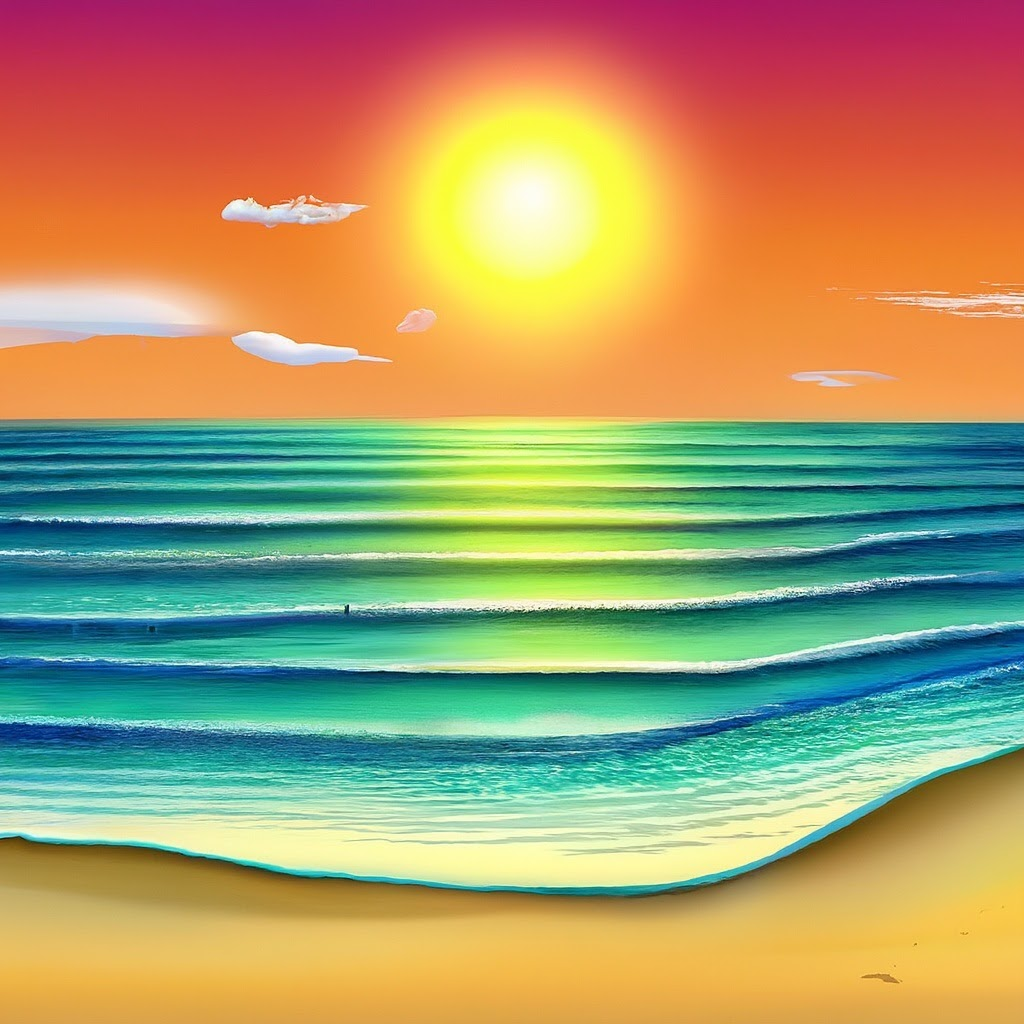

In [15]:
#@title Generate image with Imagen
image_generation_model = (
    ImageGenerationModel.from_pretrained(IMAGEN_MODEL))

image_prompt = f'{image_style} {motives}'
images = image_generation_model.generate_images(prompt=image_prompt)

images[0].show()

response
 deployed_model_id: 2875735279052783616
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768 at 0x78CB5369A0B0>


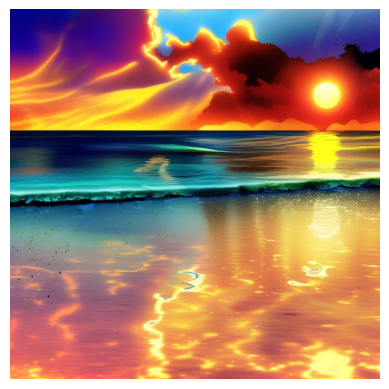

In [16]:
# @title Generate image with Stable Diffusion
images = generateImageFromPrompt(image_prompt)

for img in images:
  img1=base64_to_image(img)
  print(img1)
  plt.imshow(img1)
  plt.axis('off')
  plt.show()
